In [37]:
import copy
import sys
sys.path.insert(0, "../../")
from classes.atom_classes.atom import Atom
from classes.atom_classes.atom_file_handler import Atom_File_handler
from classes.atom_classes.atom_collection import Atom_Collection
from classes.atom_classes.atom_collection_plotter import Animator, Atom_Collection_Plotter
from classes.calculators.lennardjones import LJGauss
from classes.descriptors import CoulombMatrixSpectrum
from classes.kmeans import KMeans
import numpy as np
import matplotlib.pyplot as plt

In [38]:
class Atom_plotter(Animator):
    def __init__(self, default_cols=("C0", "C1"), markersize=50, scale_with_mass=False, alpha=1) -> None:
        super().__init__(default_cols, markersize, scale_with_mass, alpha)

In [39]:
atom_writer = Atom_File_handler()
relaxed_cols = []
for i in range(3):
    relaxed_cols += atom_writer.load_atom_collections(filename=f"relaxed_structs{i}")

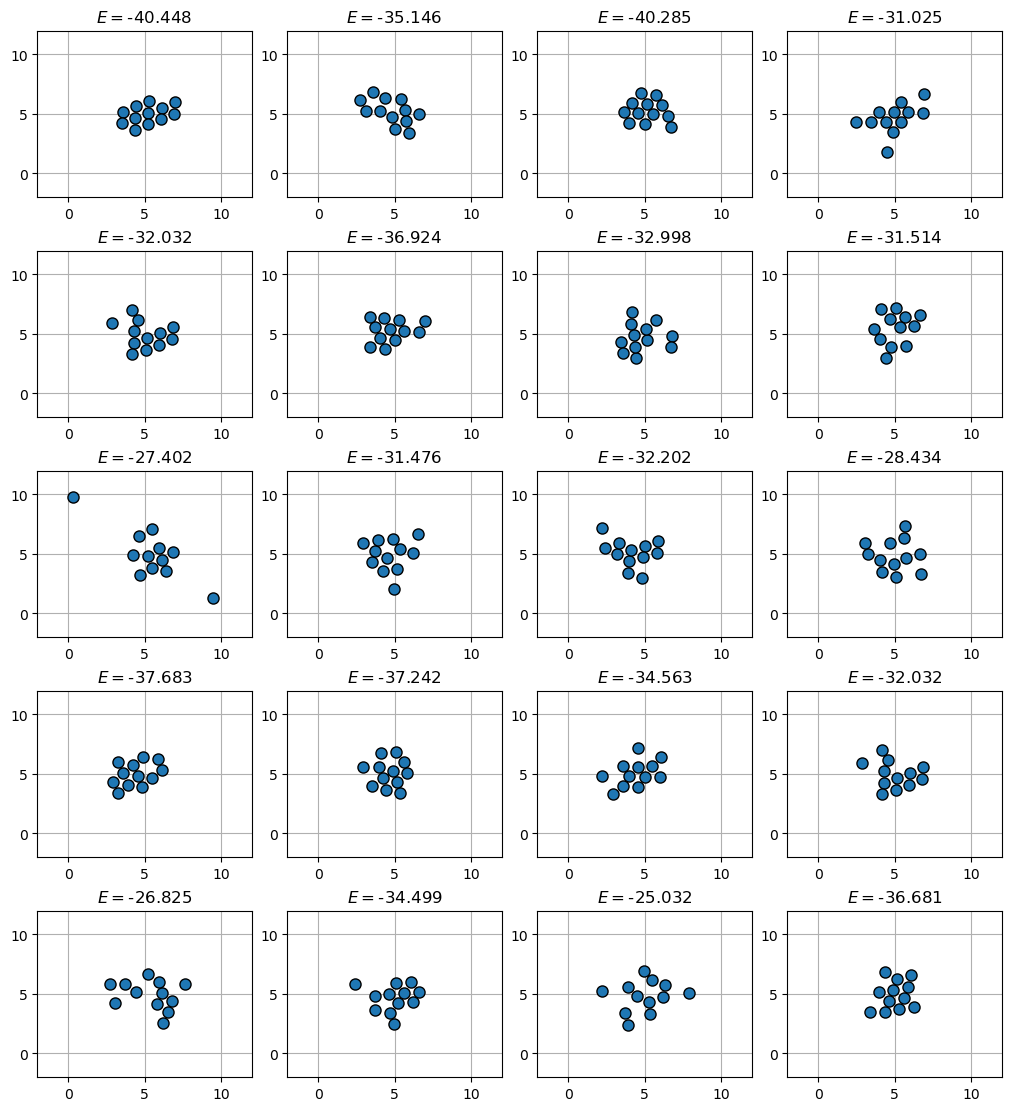

In [77]:
fig, axs = plt.subplots(5,4, figsize=(10,11), layout="constrained")
atom_plotter = Atom_plotter(markersize=8)

indices = []
plotted_cols = []
plot_num = 0
while plot_num < 20:
    index = np.random.randint(0, len(relaxed_cols), 1)[0]
    if index not in indices:
        rel_col = relaxed_cols[index]
        plotted_cols.append(rel_col)
        ax = axs.flatten()[plot_num]
        ax.grid()
        #ax.set_aspect("equal")
        ax.set_xlim([-2.0, 12.0])
        ax.set_ylim([-2.0, 12.0])
        atom_plotter(atom_col=rel_col, ax=ax)
        ax.set_title(r"$E=$"+f"{round(rel_col.get_potential_energy(),3)}")
        rel_col.reset_plot_axes()
        plot_num+=1

In [78]:
descriptor_maker = CoulombMatrixSpectrum()
descriptors = []
for rel_col in relaxed_cols:
    descriptors.append(descriptor_maker.get_descriptor(atom_col=rel_col))
descriptors = np.array(descriptors)
n_clusters = 10
kmeans = KMeans(n_clusters)
kmeans.fit(data=descriptors, init_mus=np.array([descriptors[np.random.randint(0, len(descriptors), 1)] for _ in range(n_clusters)]).squeeze(1))


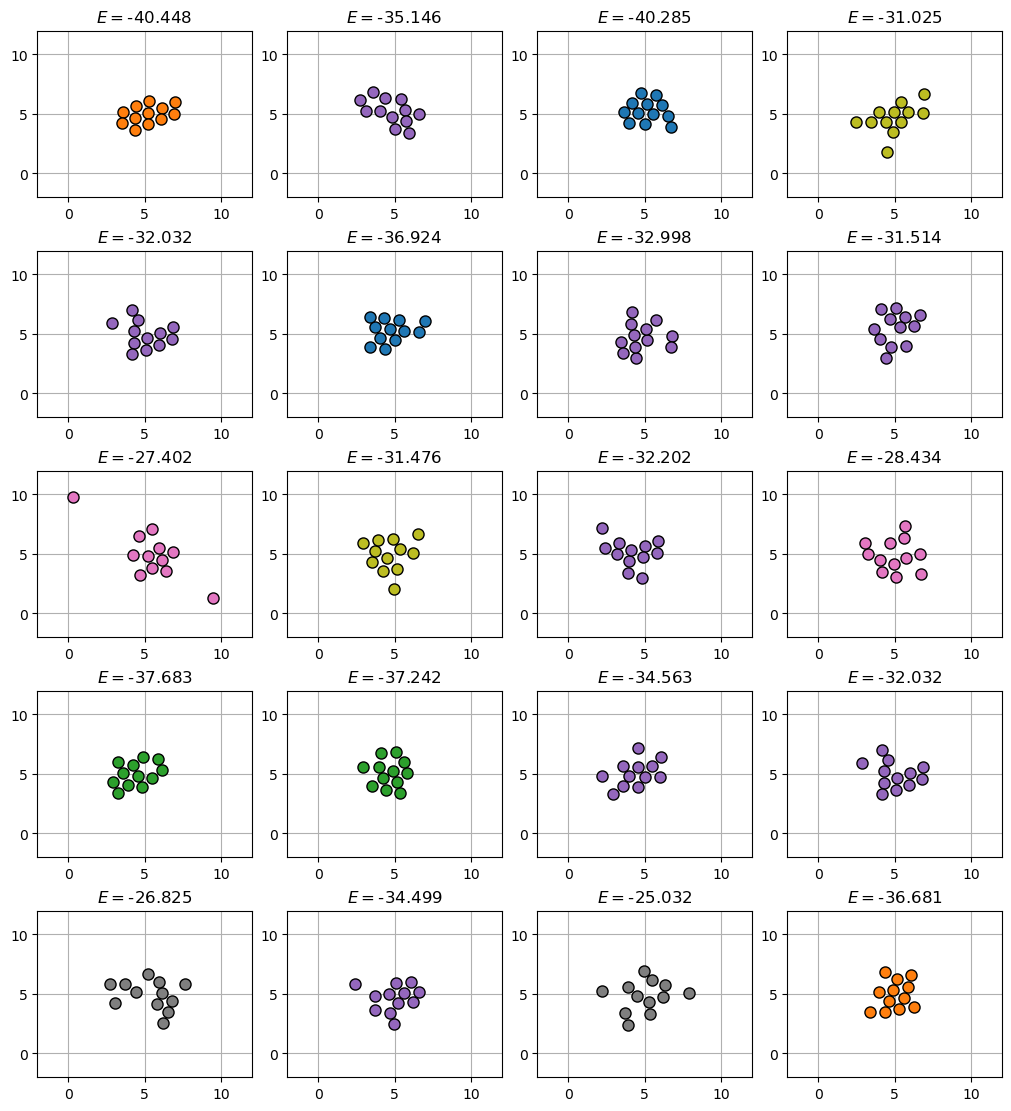

In [79]:
fig, axs = plt.subplots(5,4, figsize=(10,11), layout="constrained")
atom_plotter = Atom_plotter(markersize=8)
indices = []
for ax, plot_col in zip(axs.flatten(), plotted_cols):
    descriptor = descriptor_maker.get_descriptor(atom_col=plot_col)
    label = kmeans.predict([descriptor])
    ax.grid()
    ax.set_xlim([-2.0, 12.0])
    ax.set_ylim([-2.0, 12.0])
    atom_plotter = Atom_plotter(markersize=8, default_cols=(f"C{label[0]}", "C1"))
    atom_plotter(atom_col=plot_col, ax=ax)
    ax.set_title(r"$E=$"+f"{round(plot_col.get_potential_energy(),3)}")
    plot_col.reset_plot_axes()


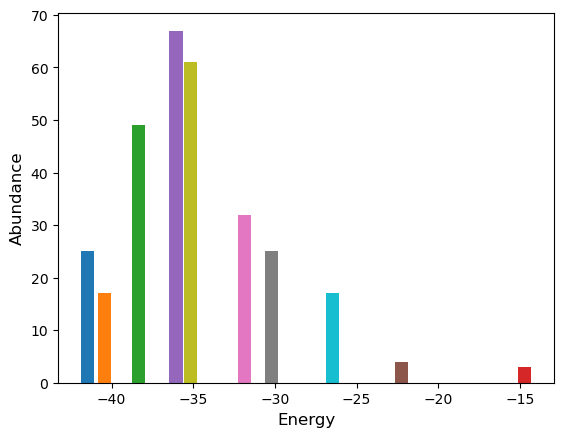

In [87]:
fig, ax = plt.subplots()
ax.set_ylabel("Abundance", fontsize=12)
ax.set_xlabel("Energy", fontsize=12)
predictions = kmeans.predict(data=descriptors)
energies_relaxed = np.array([atom_col.get_potential_energy() for atom_col in relaxed_cols])
for label in range(10):
    indices = np.argwhere(predictions == label)
    energy = np.min(energies_relaxed[indices])
    ax.bar(energy, height=len(indices), color=f"C{label}")

